### The pretraining phaze

In this chapter we implement stage 2: the training loop and model evaluation

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "torch",
        "tensorflow"]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.1
numpy version: 1.26.4
torch version: 2.0.1
tensorflow version: 2.16.2


### 5.1 Evaluating generative text models

Initialize GPT model from previous chapter

In [2]:
import torch
import torch.nn as nn


# from previous_chapters import MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
    
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores/ keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        # Shorcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shorcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )
    
    def forward(self, x):
        return self.layers(x)

    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 *x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/ torch.pi)) * (x+0.044715*torch.pow(x,3))))


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();


### 5.1.1 Using GPT to generate text

3-step process:use tokenizer to convert text to token IDs, model recieves token IDs and generates logits (prob distribution for each token in the vocab), logits are converted back to token ids.
We also use generate_text_simple() from previous chapter

In [4]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=-1)  # (batch, n_tokens + 1)

    return idx

We define 2 methods: text_to_token_ids(), token_ids_to_text() to convert between token and text representations.  
Output is not very good

In [5]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model,
                                 idx=text_to_token_ids(start_context, tokenizer),
                                 max_new_tokens=10,
                                 context_size=GPT_CONFIG_124M["context_length"]
                                 )

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingFactor incarnationDimCreated beachesPolitics wage Constant conco


### 5.1.2 Calculate the 'text generation loss': cross-entropy and perplexity

In following example, inputs and targets move by 1 position. Lets work with 2-input example

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],
                       [40, 1107, 588]])

targets = torch.tensor([[3626, 6100, 345],
                       [1107, 588, 11311]])

Below we feed inputs into the model to generate logits. Using softmax, we turn logits tensor to probability tensor of same dimension

In [7]:
with torch.no_grad():
    logits = model(inputs)
    
probas = torch.softmax(logits, dim=-1) # probability of each token in the vocab
print(probas.shape)

torch.Size([2, 3, 50257])


Below we get position of highest probability score from 50,257 tokens

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [45647],
         [ 1804]],

        [[49906],
         [15335],
         [20861]]])


Now we map output from argmax. Decode the tokens. Output is way off as model not trained yet.

In [9]:
# print(f"Target batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Output batch 1:  Armed sd doing


Below are token probabilities corresponding to targets. We need to bring them close to 1. Goal of training LLM is to maximize likelihood of correct output token.

In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([9.3956e-05, 2.8011e-05, 1.8640e-05])
Text 2: tensor([1.1259e-05, 4.3579e-05, 5.9627e-06])


In [11]:
# We compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.2727, -10.4829, -10.8902, -11.3943, -10.0409, -12.0300])


In [12]:
# Calculate the average probability of each token.
# Make this value as large as possible (i.e. as close to 0)
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.6852)


Instead of maximizing the avg log-probability, we will minimize the negetive log probability

In [13]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.6852)


We use cross-entropy implemented by pytorch

In [14]:
# Logits have shape [batch_size, num_tokens, vocab_size]
print("Logits shape: ", logits.shape)

# Targets have shape [batch_size, num_tokens]
print("Targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


For cross-entropy function we want to flatten these tensors by combining them over batch dimension

In [15]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits: ", logits_flat.shape)
print("Flattened targets: ", targets_flat.shape)

Flattened logits:  torch.Size([6, 50257])
Flattened targets:  torch.Size([6])


In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.6852)


What is perplexity? It is the exponential of cross entropy loss

In [17]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(43702.9180)


### Calculating the training and validation set losses

In [18]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [19]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [20]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the text into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]



def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [23]:
# Train/validation ratio
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
    )

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
    )

In [24]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader")
    
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader")

In [25]:
print("Train loader: ")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader: ")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader: 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader: 
torch.Size([2, 256]) torch.Size([2, 256])


1. 1st utility function to calculate cross-entropy loss for a given batch
2. 2nd utility function computes loss for a user-specified number of batches

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce no. of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking when no training
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    
print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

Training loss:  10.990534146626791
Validation loss:  10.977392196655273


### 5.2 Training an LLM

Above we implemented code to calculate training and validation loss.  
Now we implement model training code.
Some concepts to look intot in the future: lr warmup, gradient clipping, cosine annealing

In [28]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen  = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # Model set to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # calc. loss gradients
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            # Evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, \
                                                      device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss: .3f}")
        
        # Print a simple text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

Start training...

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.116, Val loss  10.174
Ep 1 (Step 000005): Train loss 8.177, Val loss  8.408
Every effort moves you,,,,,,...,,,,,.,,,,,,,,,,,,,,.,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 6.950, Val loss  7.135
Ep 2 (Step 000015): Train loss 6.275, Val loss  6.713
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Step 000020): Train loss 6.204, Val loss  6.657
Ep 3 (Step 000025): Train loss 6.093, Val loss  6.695
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 4 (Step 000030): Train loss 6.074, Val loss  6.756
Ep 4 (Step 000035): Train loss 6.023, Val loss  6.769
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 5 (Step 000040): Train loss 6.033, Val loss  6.846
Every effort moves you,....                                             
Ep 6 (Step 000045): Train loss 5.989, Val loss  6.845
Ep 6 (Step 000050): Train loss 6.044, Val loss  6.808
Every effort moves you,,,,,,,,,,,,,,,,,

Overfitting occurs because we are iterating over a smal training data again and again.
It basically memorizes the training data. Later we will see some decoding strategies to prevent this memorization.

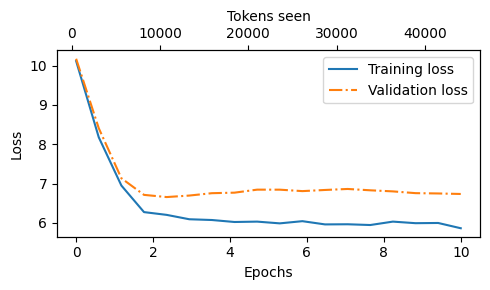

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 5.3 Decoding strategies to control randomness

We use generate_text_simple() to generate next token.

In [31]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,


If we execute above method multiple times, we will get the same output.
Two decoding strategies: temperature scaling and topk sampling

#### Temperature scaling:
Instead of using torch.argmax() to sample token having highest probability of being next token, we use torch.multinomial(probs, num_samples=1), sampling from a probability distribution.

Below is a recap example of how to generate next token...

In [32]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [44]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


Basically what we did above was that instead of returning result of argmax() we sampled most likely token from a softmax distribution

In [36]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
        
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


We can control the distribution process through process called 'temperature scaling'

In [46]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]


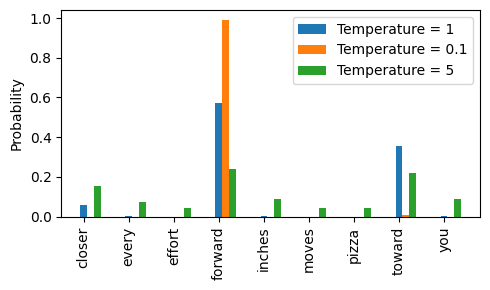

In [47]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

0.1 has sharper distribution

#### topk samplings:
We do this to increase output diversity of even higher temperature values and reduce probability of nonsensical tokens.

In [48]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [51]:
# %%timeit

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,    inf,    inf, 6.7500,    inf,    inf,    inf, 6.2800,    inf])


In [52]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])


### 5.3.3 Modifying text generation functions

Using the above 2 concepts (temperature and topk samplings) to modify the generate_simple()

In [53]:
def generate(model, idx, max_new_tokens, context_size, 
             temperature=0.0, top_k=None, eos_id=None):
    
    # For loop is same as before..
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        # Filter logits with topk sampling
        if top_k is not None:
            # keep only topk values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, 
                                 torch.tensor(float("-inf")).to(logits.device), logits)
            
            if temperature > 0.0:
                logits = logits / temperature
            
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break
        
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [54]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4    
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you have I a in one to a I it was of to to-- and


### 5.4 Loading and saving model weights in PyTorch

Save..

In [55]:
torch.save(model.state_dict(), "model.pth")

Load..

In [56]:
model = GPTModel(GPT_CONFIG_124M)
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))

/Users/Z004XN6/PycharmProjects/lessr/lessr_venv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

We use 'adaptive optimizers' like Adam and AdamW instead of SGD. These optimiers have additonal parameters that can be used later to continue pretrining, s we can save them using code below:

In [59]:
torch.save(
    {"model_state_dict": model.state_dict(),
     "optimizer_state_dict": optimizer.state_dict(),
     },
    "model_with_optimizer.pth"
)


In [61]:
checkpoint = torch.load("model_with_optimizer.pth", weights_only=True)

model=GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

### 5.5 Loading pretrained weights from OpenAI

In [62]:
print("Tensorflow version: ", version("tensorflow"))
print("tqdm version: ", version("tqdm"))

Tensorflow version:  2.16.2
tqdm version:  4.62.3


In [63]:
from gpt_download import download_and_load_gpt2

2025-01-25 13:09:52.219195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Z004XN6/PycharmProjects/lessr/lessr_venv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [64]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|███████████████████████████| 77.0/77.0 [00:00<00:00, 4.05kiB/s]
encoder.json: 100%|███████████████████████| 1.04M/1.04M [00:00<00:00, 9.01MiB/s]
hparams.json: 100%|█████████████████████████| 90.0/90.0 [00:00<00:00, 15.6kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████| 498M/498M [00:39<00:00, 12.5MiB/s]
model.ckpt.index: 100%|███████████████████| 5.21k/5.21k [00:00<00:00, 1.85MiB/s]
model.ckpt.meta: 100%|██████████████████████| 471k/471k [00:00<00:00, 7.23MiB/s]
vocab.bpe: 100%|████████████████████████████| 456k/456k [00:00<00:00, 7.18MiB/s]


In [65]:
print("Settings: ", settings)

print(params["wte"])
print("Token embeddings weight tensor dimensions:", params["wte"].shape)


Settings:  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embeddings weight tensor dimensions: (50257, 768)


Transfer above loaded model to our GPTModel...

In [66]:
# Define model config in a dictionary
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 26},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

Assign OpenAI weights to corresponding weights of GPTModel instance

In [67]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [70]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
            gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
            gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
            gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
            gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
            gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
            gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);